### Read a netcdf formated smi par file and plot on a laea projection

this notebook reads and maps par in standard mapped image format

https://oceancolor.gsfc.nasa.gov/docs/technical/ocean_level-3_smi_products.pdf

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from e582utils.data_read import download
import warnings
warnings.filterwarnings("ignore")
import pyproj
from e582lib.map_slices import  make_xy
from rasterio.transform import from_bounds
from pyresample import image, geometry

l3file='A2007008.L3m_DAY_PAR_par_9km.nc'
download(l3file)

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/A2007008.L3m_DAY_PAR_par_9km.nc
writing to: A2007008.L3m_DAY_PAR_par_9km.nc

A2007008.L3m_DAY_PAR_par_9km.nc already exists
and is 14345758 bytes
will not overwrite



#### Extract the variables and the _FillValue and replace missing data with np.nan

See http://unidata.github.io/netcdf4-python/

In [2]:
with Dataset(l3file,'r') as ncdat:
    ncdat.set_auto_mask(False)
    par=ncdat.variables['par'][...]
    lat=ncdat.variables['lat'][...]
    lon=ncdat.variables['lon'][...]
    fill_value=ncdat.variables['par']._FillValue
hit= par == fill_value
par[hit] = np.nan

#### set up the palette

In [3]:
cmap=matplotlib.cm.YlGn_r  #see http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps
cmap.set_over('r')
cmap.set_under('0.85')
cmap.set_bad('0.75') #75% grey
vmin= 0
vmax= 100
the_norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax,clip=False)

#### plot using https://nsidc.org/data/atlas/epsg_4326.html

/Users/phil/mini35/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py


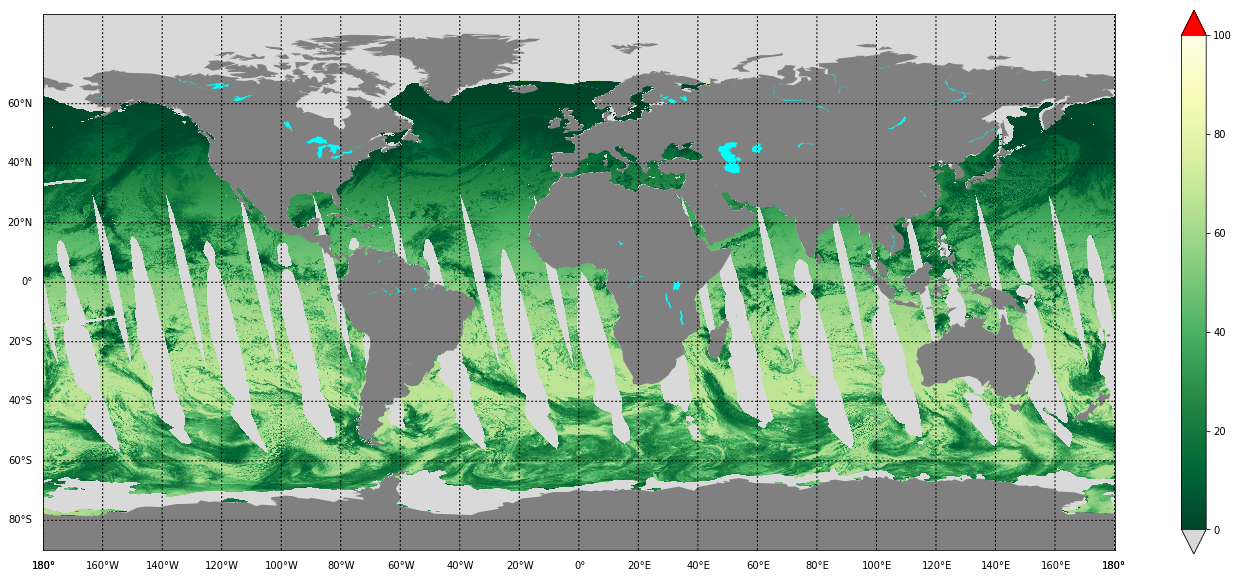

In [4]:
%matplotlib inline
import mpl_toolkits
print(mpl_toolkits.basemap.__file__)
bmap=Basemap(ellps='WGS84',projection='cyl')
lonvals,latvals = np.meshgrid(lon,lat)
fig, ax = plt.subplots(1,1,figsize=(24,20))
xvals,yvals=bmap(lonvals,latvals)
cs=bmap.pcolormesh(xvals,yvals,par,cmap=cmap,norm=the_norm)
cs=bmap.imshow(par,cmap=cmap,norm=the_norm,origin='upper')
bmap.fillcontinents(color='grey',lake_color='cyan');
colorbar=fig.colorbar(cs, shrink=0.5, pad=0.05,extend='both')
parallels=np.arange(-80, 80, 20)
meridians=np.arange(-180, 180, 20)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],\
                  fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],\
                  fontsize=10, latmax=90);

### write a function that returns slices to extract a lon/lat box

In [5]:
def find_box(lon,lat,ll_lat,ll_lon,ur_lat,ur_lon):
    """
    Given 1-d arrays of longitude and latitude, find slices that
    would return all values within a 2-d lat and lon box bounded
    by lower left and ur right corners
    
    Parameters
    ----------
    
    lon: 1-d ndarray of longitudes (smallest to larges)
    
    lat: 1-d ndarray of latitudes (most positive to most negative)
    
    ll_lat,ll_lon: float
       lower left latitude and longitude, in degrees
       
    ur_lat,ur_lon: float
        upper right latitude and logitude, in degrees
        
    Returns
    -------
    
    row_slice, col_slice: python slice objects
        slices to use to subset the image
    
    """
    lon_index=np.searchsorted(lon,ur_lon)
    lat_index=np.searchsorted(lat[::-1],ur_lat)
    lat_index=len(lat) - lat_index
    ur_lat_index=lat_index
    ur_lon_index=lon_index
    lon_index=np.searchsorted(lon,ll_lon)
    lat_index=np.searchsorted(lat[::-1],ll_lat)
    lat_index=len(lat) - lat_index
    ll_lat_index=lat_index
    ll_lon_index=lon_index
    row_slice=slice(ur_lat_index,ll_lat_index)
    col_slice=slice(ll_lon_index,ur_lon_index)
    return row_slice,col_slice

### write a function that takes a dataslice with a eqc projection and reprojects to laea

In [6]:
def map_slice(lon_slice,lat_slice,data_slice):
    """
    given a slice, return data mapped to a laea projection and the crs dicitonary
    for the projection
    
    Parameters
    ----------
    
    lon_slice,lat_slice,data_slice: 2d arrays (float)
       3 2-d arrays of the same shape giving longitudes, latitudes and data values
       for each pixel
       
    Returns
    -------
    
    mapped_data:  2d array (float)
       2-d array with same number of rows and columns as data_slice, projected
       to new coordinate system
    
    dst_crs: dict
       dictionary with keys needed by pyprojto create the destination projection
    
    """
    llcrnrlat=lat_slice[-1,0]
    llcrnrlon=lon_slice[-1,0]
    urcrnrlat=lat_slice[0,-1]
    urcrnrlon=lon_slice[0,-1]
    src_crs=dict(units='m',proj='eqc',datum='WGS84')
    src_proj=pyproj.Proj(src_crs)
    llcrnrx,llcrnry=src_proj(llcrnrlon,llcrnrlat)
    urcrnrx,urcrnry=src_proj(urcrnrlon,urcrnrlat)
    src_extent=[llcrnrx,llcrnry,urcrnrx,urcrnry]
    src_height,src_width = data_slice.shape
    
    from_def = geometry.AreaDefinition('src', 'src image', 'area_src',
                                   src_crs,
                                   src_width, src_height,
                                   src_extent)
    lat_0=(lat_slice[0,0]+lat_slice[-1,0])/2.
    lon_0=(lon_slice[0,0]+lon_slice[0,-1])/2.
    dst_crs={'datum': 'WGS84','lat_0': lat_0,'lon_0': lon_0,'proj': 'laea'}
    dst_proj=pyproj.Proj(dst_crs)
    llcrnrx,llcrnry=dst_proj(llcrnrlon,llcrnrlat)
    urcrnrx,urcrnry=dst_proj(urcrnrlon,urcrnrlat)
    dst_extent=[llcrnrx,llcrnry,urcrnrx,urcrnry]
    to_def = geometry.AreaDefinition('big', 'big image','area_big',
                                   dst_crs,
                                   src_width,src_height,
                                   dst_extent)
    from_nn = image.ImageContainerNearest(par_slice,from_def, radius_of_influence=50000)
    to_nn = from_nn.resample(to_def)
    mapped_data = to_nn.image_data
    return mapped_data,dst_crs

### write a function that takes the laea mapped data and constructs a basemap_dict plus transform


Note that you need to use basemap to get the transform corners, because basemap and pyproj sometimes make different choices about easting (x_0) and northing (y_0)

In [7]:
def make_basemap(lon_slice,lat_slice,mapped_crs):
    """
    function that takes lon,lat values and a crs dictionary
    and create a dictionary to be used by basemap
    
    Parameters
    ----------
    
    lon_slice,lat_slice: 2d arrays
       lon and lat values of each pixel
       
    mapped_crs:  dict
       crs dictionary returned from map slice
       
    Returns
    -------
    
    basemap_args: dict
       dictionary used to create basemap instance to plot the slice
       
    transform: Affine object
       affine transform needed to get xvals and yvals for basemap pcolormesh
       
    """
    dst_proj=pyproj.Proj(mapped_crs)
    basemap_args=dict(llcrnrlat=lat_slice[-1,0],llcrnrlon=lon_slice[-1,0],
                 urcrnrlat=lat_slice[0,-1],urcrnrlon=lon_slice[0,-1])
    basemap_args['ellps']=mapped_crs['datum']
    basemap_args['projection']=mapped_crs['proj']
    basemap_args['resolution']='c'
    for key in ['lon_0','lat_0']:
        basemap_args[key]=mapped_crs[key]
    height,width=lat_slice.shape
    bmap=Basemap(**basemap_args)
    llcrnrx,llcrnry,urcrnrx,urcrnry=bmap.llcrnrx,bmap.llcrnry,bmap.urcrnrx,bmap.urcrnry
    transform = from_bounds(llcrnrx, llcrnry, urcrnrx, urcrnry, width, height)
    return basemap_args,transform

### Pick a box in thePacific and get the slice

In [8]:
ur_lat=50
ur_lon=-120
ll_lat=20
ll_lon=-170

ur_lat=30
ur_lon=-110
ll_lat=20
ll_lon=-130

row_slice,col_slice=find_box(lon,lat,ll_lat,ll_lon,ur_lat,ur_lon)
lat_slice=latvals[row_slice,col_slice]
lon_slice=lonvals[row_slice,col_slice]

### Make a mercator plot to show the general layout

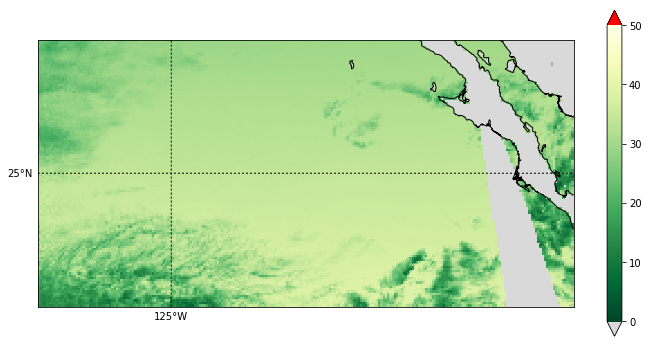

In [9]:
basemap_args=dict(llcrnrlat=lat_slice[-1,0],llcrnrlon=lon_slice[-1,0],
                 urcrnrlat=lat_slice[0,-1],urcrnrlon=lon_slice[0,-1],ellps='WGS84',
                 projection='cyl')



fig, ax = plt.subplots(1,1,figsize=(12,12))
basemap_args.update(dict(resolution='i',ax=ax))
bmap = Basemap(**basemap_args)
xvals, yvals=bmap(lon_slice,lat_slice)
par_slice=par[row_slice,col_slice]
vmin= 0
vmax= 50
the_norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
cs=bmap.pcolormesh(xvals,yvals,par_slice,cmap=cmap,norm=the_norm)
colorbar=fig.colorbar(cs, shrink=0.5, pad=0.05,extend='both')
bmap.drawcoastlines()
parallels=np.arange(20, 60, 5)
meridians=np.arange(-170, -120,5)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],\
                  fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],\
                  fontsize=10, latmax=90);

### Reproject using our  map_slice and make_basemap functions


So now -- do a reprojection from pyproj eqc to pyproj laea  -- keep the lon,lat of the map
corners the same in the new projection and the same number of pixels in the destination raster

In [10]:
mapped_data,dst_crs=map_slice(lon_slice,lat_slice,par_slice)
basemap_args,transform=make_basemap(lon_slice,lat_slice,dst_crs)

### plot the reprojected image as a raw bitmap

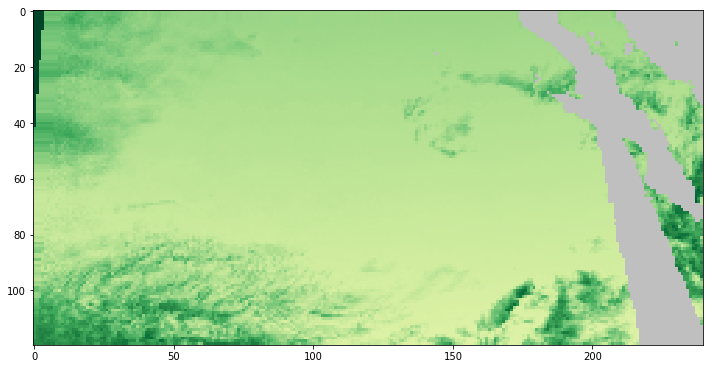

In [11]:
fig,ax=plt.subplots(1,1,figsize=(12,12))
ax.imshow(mapped_data,cmap=cmap,norm=the_norm,origin='upper');

### Put the coastline on the map

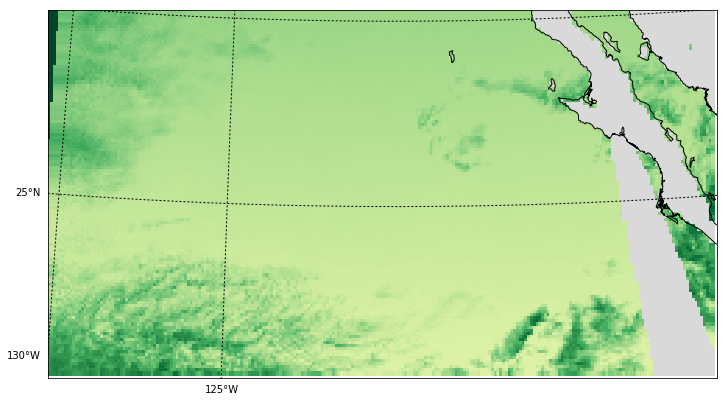

In [12]:
fig,ax = plt.subplots(1,1,figsize=(12,12))
basemap_args['ax']=ax
basemap_args['resolution']='i'
bmap=Basemap(**basemap_args)
height,width=mapped_data.shape
xvals,yvals=make_xy(0,height,0,width,transform)
result_masked=np.ma.masked_invalid(mapped_data)
bmap.pcolormesh(xvals,yvals,mapped_data,cmap=cmap,norm=the_norm)
bmap.drawcoastlines();
parallels=np.arange(20, 60, 5)
meridians=np.arange(-170, -120,5)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],\
                  fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[1, 1, 0, 1],\
                  fontsize=10, latmax=90);

In [13]:
bmap.projparams

{'a': 6378137.0,
 'b': 6356752.314245179,
 'lat_0': 24.999998092651367,
 'lon_0': -119.99999618530273,
 'proj': 'laea',
 'units': 'm',
 'x_0': 1040846.8119866211,
 'y_0': 512586.6595672663}

In [14]:
bmap.proj4string

'+proj=laea +a=6378137.0 +b=6356752.314245179 +units=m +lat_0=24.999998092651367 +lon_0=-119.99999618530273 +x_0=1040846.8119866211 +y_0=512586.6595672663 '

In [15]:
test=pyproj.Proj(bmap.projparams)

In [16]:
test.srs

'+proj=laea +a=6378137.0 +b=6356752.314245179 +units=m +lat_0=24.999998092651367 +lon_0=-119.99999618530273 +x_0=1040846.8119866211 +y_0=512586.6595672663 '

In [19]:
test.proj_version

4.92

In [20]:
out=bmap.projparams

In [21]:
out['x_0']=0
out['y_0']=0

In [22]:
out

{'a': 6378137.0,
 'b': 6356752.314245179,
 'lat_0': 24.999998092651367,
 'lon_0': -119.99999618530273,
 'proj': 'laea',
 'units': 'm',
 'x_0': 0,
 'y_0': 0}

In [25]:
out['projection']=out['proj']

In [27]:
del out['proj']

In [29]:
out['ellps']='WGS84'

In [31]:
del out['a']

In [32]:
del out['b']

In [34]:
del out['units']

In [35]:
out

{'ellps': 'WGS84',
 'lat_0': 24.999998092651367,
 'lon_0': -119.99999618530273,
 'projection': 'laea',
 'x_0': 0,
 'y_0': 0}

In [36]:
newmap=Basemap(**out)

TypeError: __init__() got an unexpected keyword argument 'x_0'